In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317146 sha256=f493095c530a4f09d5c3a3b22792bca6c51e332376abfd8787538405b202bc0d
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


### Give Spark more memory for operations

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .config('spark.driver.memory', '24g')\
        .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/06 23:30:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
print(spark.sparkContext._conf.get('spark.driver.memory'))

24g


# 1. Read Data and Analyze

In [ ]:
twitter_df = spark.read.load("/content/Sentiment140.csv",
                         format="csv",
                         sep=",",
                         inferSchema="true",
                         header="false"
                         ).toDF('label', 'id', 'time', 'a', 'b', 'text')

In [ ]:
twitter_df.show(5)

+-----+----------+--------------------+--------+---------------+--------------------+
|label|        id|                time|       a|              b|                text|
+-----+----------+--------------------+--------+---------------+--------------------+
|    0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|    0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|    0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|    0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|    0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+-----+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



### İmporting Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

from pyspark.sql.functions import udf, col, lower, trim, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(twitter_df.count(), len(twitter_df.columns)))

The shape of the dataset is 1600000 rows by 6 columns


### 4 : For Positive Values

### 0 : For Negative Values

In [ ]:
twitter_df.select('label').distinct().collect()

[Row(label=4), Row(label=0)]

In [ ]:
print(f"There is {twitter_df[twitter_df['label'] == 4].count()} positive values")
print(f"There is {twitter_df[twitter_df['label'] == 0].count()} negative values")

There is 800000 positive values


There is 800000 negative values


### Positive Tweet Examples

In [ ]:
twitter_df[twitter_df['label'] == 4].show(5, truncate=False)

+-----+----------+----------------------------+--------+-----------+-----------------------------------------------------------------------------------------------------------------------------------------+
|label|id        |time                        |a       |b          |text                                                                                                                                     |
+-----+----------+----------------------------+--------+-----------+-----------------------------------------------------------------------------------------------------------------------------------------+
|4    |1467822272|Mon Apr 06 22:22:45 PDT 2009|NO_QUERY|ersle      |I LOVE @Health4UandPets u guys r the best!!                                                                                              |
|4    |1467822273|Mon Apr 06 22:22:45 PDT 2009|NO_QUERY|becca210   |im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!                                

### Negative Tweet Examples

In [ ]:
twitter_df[twitter_df['label'] == 0].show(5, truncate=False)

+-----+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|label|id        |time                        |a       |b              |text                                                                                                               |
+-----+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|0    |1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
|0    |1467810672|Mon Apr 06 22:19:49 PDT 2009|NO_QUERY|scotthamilton  |is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    |
|0    |1467810917|Mon Apr 06 22:19:53 PDT 2009|NO_QUERY

### Check Null Variables

In [ ]:
twitter_df.where(col("text").isNull()).count()

0

### Drop Duplicates

In [ ]:
twitter_df = twitter_df.dropDuplicates()
print(f"Number of rows in the dataframe after dropping the duplicates: {twitter_df.count()}")

Number of rows in the dataframe after dropping the duplicates: 1600000


### Case Normalization

In [ ]:
twitter_df.show(5, truncate=False)

+-----+----------+----------------------------+--------+------------+-------------------------------------------------------------------------------------------------------------------------------------+
|label|id        |time                        |a       |b           |text                                                                                                                                 |
+-----+----------+----------------------------+--------+------------+-------------------------------------------------------------------------------------------------------------------------------------+
|0    |1467811372|Mon Apr 06 22:20:00 PDT 2009|NO_QUERY|joy_wolf    |@Kwesidei not the whole crew                                                                                                         |
|0    |1468032862|Mon Apr 06 23:21:35 PDT 2009|NO_QUERY|lamarmcarter|happy for Coach Stringer (HOF c/o 2009!)...now if I can only finish my term paper on her                           

In [ ]:
def caseNormalization(df, column_name):
  df = df.withColumn(column_name, lower(col(column_name)))
  return df

In [ ]:
twitter_df = caseNormalization(twitter_df, 'text')
twitter_df.show(5, truncate=False)

+-----+----------+----------------------------+--------+------------+-------------------------------------------------------------------------------------------------------------------------------------+
|label|id        |time                        |a       |b           |text                                                                                                                                 |
+-----+----------+----------------------------+--------+------------+-------------------------------------------------------------------------------------------------------------------------------------+
|0    |1467811372|Mon Apr 06 22:20:00 PDT 2009|NO_QUERY|joy_wolf    |@kwesidei not the whole crew                                                                                                         |
|0    |1468032862|Mon Apr 06 23:21:35 PDT 2009|NO_QUERY|lamarmcarter|happy for coach stringer (hof c/o 2009!)...now if i can only finish my term paper on her                           

### Word Cloud

In [ ]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
texts_ = []
pandasDF = twitter_df.toPandas()

##### Wordcloud for Positive Values

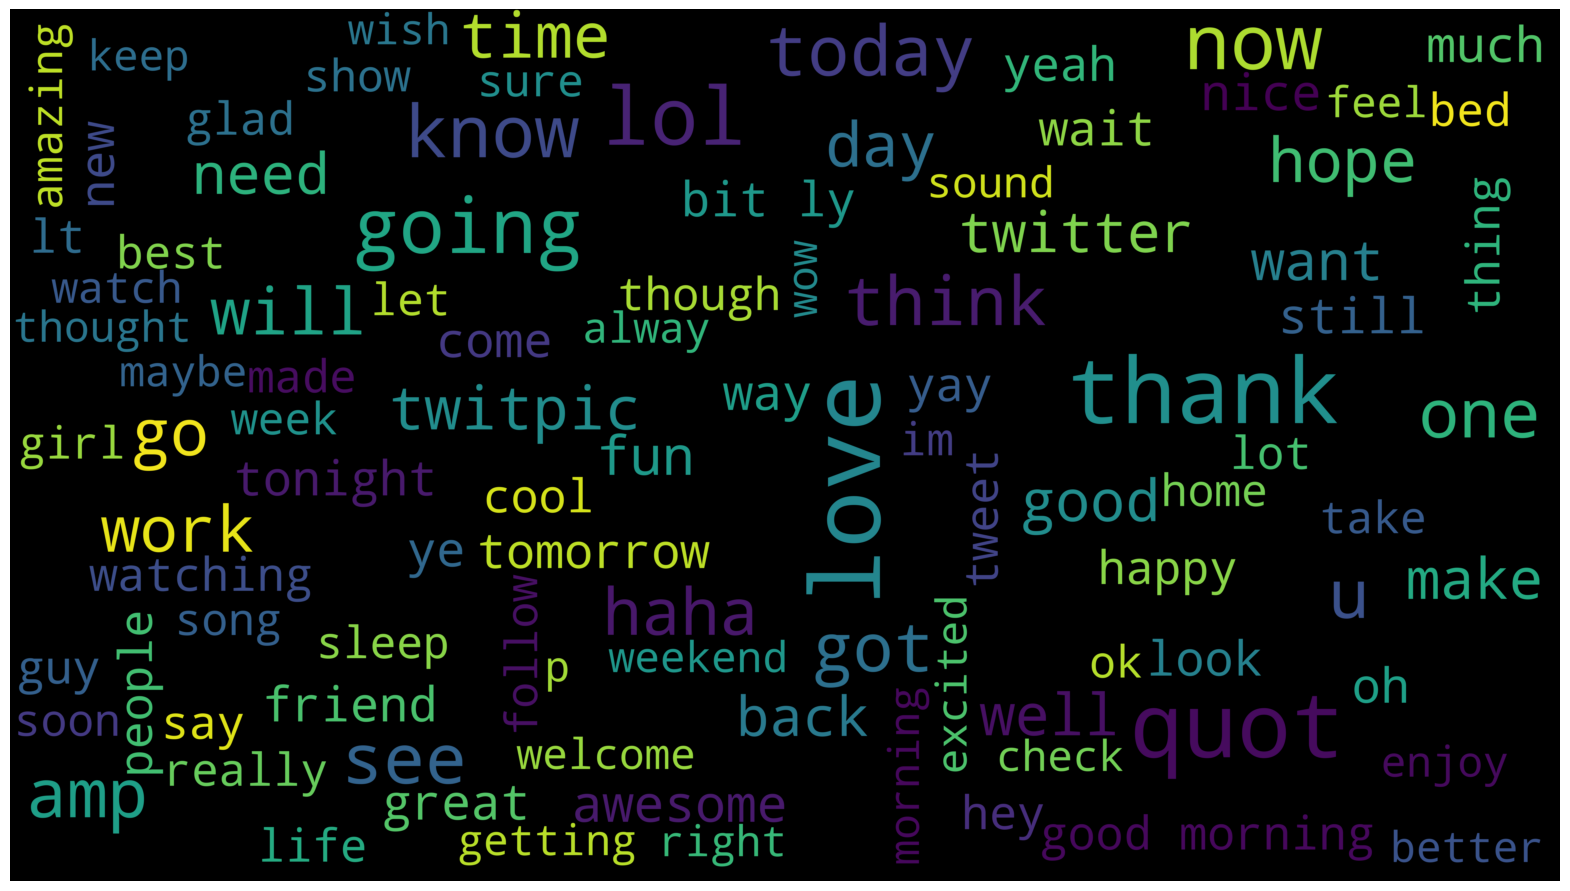

In [ ]:
from wordcloud import WordCloud #Word visualization

text_ = ""

word_cloud_text = ''.join(pandasDF[pandasDF["label"]==4].text)
#Creation of wordcloud
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=1600,
    height=900
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(20,16))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

##### Wordcloud for Negative Values

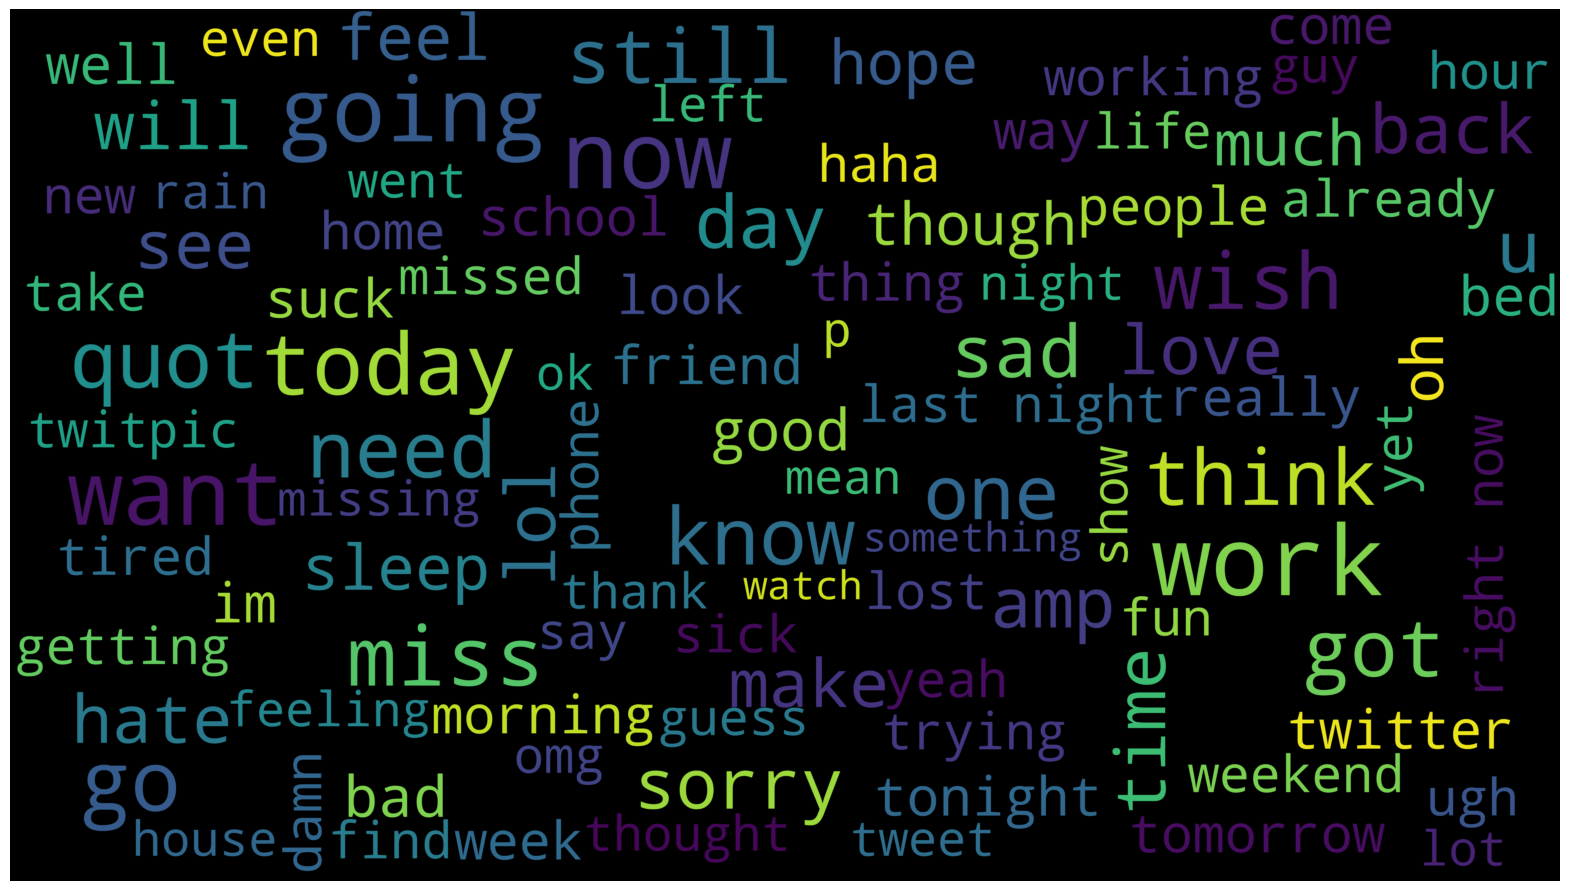

In [ ]:
from wordcloud import WordCloud #Word visualization

text_ = ""

word_cloud_text = ''.join(pandasDF[pandasDF["label"]==0].text)
#Creation of wordcloud
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=1600,
    height=900
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(20,16))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# 2. Text Cleaning

#### 2.1 Trimming

In [ ]:
twitter_df.show(5,truncate=False)

+-----+----------+----------------------------+--------+------------+-------------------------------------------------------------------------------------------------------------------------------------+
|label|id        |time                        |a       |b           |text                                                                                                                                 |
+-----+----------+----------------------------+--------+------------+-------------------------------------------------------------------------------------------------------------------------------------+
|0    |1467811372|Mon Apr 06 22:20:00 PDT 2009|NO_QUERY|joy_wolf    |@kwesidei not the whole crew                                                                                                         |
|0    |1468032862|Mon Apr 06 23:21:35 PDT 2009|NO_QUERY|lamarmcarter|happy for coach stringer (hof c/o 2009!)...now if i can only finish my term paper on her                           

In [ ]:
def trimming(df, column_name):
  return df.withColumn(column_name, trim(col(column_name)))

In [ ]:
twitter_df = trimming(twitter_df, 'text')
twitter_df.show(5, truncate=False)

+-----+----------+----------------------------+--------+------------+------------------------------------------------------------------------------------------------------------------------------------+
|label|id        |time                        |a       |b           |text                                                                                                                                |
+-----+----------+----------------------------+--------+------------+------------------------------------------------------------------------------------------------------------------------------------+
|0    |1467811372|Mon Apr 06 22:20:00 PDT 2009|NO_QUERY|joy_wolf    |@kwesidei not the whole crew                                                                                                        |
|0    |1468032862|Mon Apr 06 23:21:35 PDT 2009|NO_QUERY|lamarmcarter|happy for coach stringer (hof c/o 2009!)...now if i can only finish my term paper on her                               

#### 2.2 Filter Punctuation and Extra Whitespaces

In [ ]:
def punctuation(df, column_name):
  df_ = df.withColumn(column_name, regexp_replace(col(column_name), "[^a-zA-Z\\s]", ""))
  return df_.withColumn(column_name, trim(regexp_replace(col(column_name), " +", " ")))

In [ ]:
twitter_df = punctuation(twitter_df, 'text')
twitter_df.show(5, truncate=False)

+-----+----------+----------------------------+--------+------------+-----------------------------------------------------------------------------------------------------------------------------+
|label|id        |time                        |a       |b           |text                                                                                                                         |
+-----+----------+----------------------------+--------+------------+-----------------------------------------------------------------------------------------------------------------------------+
|0    |1467811372|Mon Apr 06 22:20:00 PDT 2009|NO_QUERY|joy_wolf    |kwesidei not the whole crew                                                                                                  |
|0    |1468032862|Mon Apr 06 23:21:35 PDT 2009|NO_QUERY|lamarmcarter|happy for coach stringer hof co now if i can only finish my term paper on her                                                |
|0    |1468093726|Mo

#### 2.3 Tokenization

In [ ]:
def tokenize(df, column_name):
  tokenizer = Tokenizer(inputCol=column_name, outputCol="tokens")
  return tokenizer.transform(df).cache()

In [ ]:
twitter_df = tokenize(twitter_df, 'text')
twitter_df.show(5, truncate=False)

+-----+----------+----------------------------+--------+------------+-----------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------+
|label|id        |time                        |a       |b           |text                                                                                                                         |tokens                                                                                                                                              |
+-----+----------+----------------------------+--------+------------+-----------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------

#### 2.4 StopWords Removal

In [ ]:
def stopword(df, tokens_column_name):
  stopwords_remover = StopWordsRemover(inputCol=tokens_column_name, outputCol="terms")
  return stopwords_remover.transform(df).cache()

In [ ]:
twitter_df = stopword(twitter_df, 'tokens')
twitter_df.show(5)

+-----+----------+--------------------+--------+------------+--------------------+--------------------+--------------------+
|label|        id|                time|       a|           b|                text|              tokens|               terms|
+-----+----------+--------------------+--------+------------+--------------------+--------------------+--------------------+
|    0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|    joy_wolf|kwesidei not the ...|[kwesidei, not, t...|[kwesidei, whole,...|
|    0|1468032862|Mon Apr 06 23:21:...|NO_QUERY|lamarmcarter|happy for coach s...|[happy, for, coac...|[happy, coach, st...|
|    0|1468093726|Mon Apr 06 23:40:...|NO_QUERY|  purplewolf|mums been taken t...|[mums, been, take...|[mums, taken, hos...|
|    0|1468135920|Mon Apr 06 23:54:...|NO_QUERY|  erikafradd|i hate cooking di...|[i, hate, cooking...|[hate, cooking, d...|
|    0|1468167936|Tue Apr 07 00:05:...|NO_QUERY|dontlookaway|body clock still ...|[body, clock, sti...|[body, clock, sti...|


### Stemming (Snowball)

In [ ]:
def stem(df, terms_column_name):
  stemmer = SnowballStemmer(language="english")
  stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
  terms_stemmed_df = df.withColumn("terms_stemmed", stemmer_udf(terms_column_name)).cache()
  return terms_stemmed_df

twitter_df = stem(twitter_df, 'terms')
twitter_df.show(5)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+-----+----------+--------------------+--------+------------+--------------------+--------------------+--------------------+--------------------+
|label|        id|                time|       a|           b|                text|              tokens|               terms|       terms_stemmed|
+-----+----------+--------------------+--------+------------+--------------------+--------------------+--------------------+--------------------+
|    0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|    joy_wolf|kwesidei not the ...|[kwesidei, not, t...|[kwesidei, whole,...|[kwesidei, whole,...|
|    0|1468032862|Mon Apr 06 23:21:...|NO_QUERY|lamarmcarter|happy for coach s...|[happy, for, coac...|[happy, coach, st...|[happi, coach, st...|
|    0|1468093726|Mon Apr 06 23:40:...|NO_QUERY|  purplewolf|mums been taken t...|[mums, been, take...|[mums, taken, hos...|[mum, taken, hosp...|
|    0|1468135920|Mon Apr 06 23:54:...|NO_QUERY|  erikafradd|i hate cooking di...|[i, hate, cooking...|[hate, cooking, d...|

# 3. Embedding

#### There are three alternatives Word2Vec, CountVectorizer and HashTF

### 3.1 Word2Vec

In [ ]:
def word2vec(df, column_name="terms",random_seed=42,embedding_size=30, model=None):
  from pyspark.ml.feature import Word2Vec

  if model is None:
    word2vec = Word2Vec(vectorSize=embedding_size, minCount=5, inputCol=column_name, outputCol="features", seed=random_seed)
    model = word2vec.fit(df)
  features = model.transform(df).cache()

  return model, features

In [ ]:
word2vecModel, twitter_w2v_df = word2vec(twitter_df, column_name="terms_stemmed", embedding_size=100)
twitter_w2v_df.show(5)

23/05/06 23:41:32 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


+-----+----------+--------------------+--------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|label|        id|                time|       a|           b|                text|              tokens|               terms|       terms_stemmed|            features|
+-----+----------+--------------------+--------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|    joy_wolf|kwesidei not the ...|[kwesidei, not, t...|[kwesidei, whole,...|[kwesidei, whole,...|[-0.0173879160235...|
|    0|1468032862|Mon Apr 06 23:21:...|NO_QUERY|lamarmcarter|happy for coach s...|[happy, for, coac...|[happy, coach, st...|[happi, coach, st...|[0.01152233942411...|
|    0|1468093726|Mon Apr 06 23:40:...|NO_QUERY|  purplewolf|mums been taken t...|[mums, been, take...|[mums, taken, hos...|[mum, taken, hosp...|[-0.1016788989305...

### 3.2 CountVectorizer

In [ ]:
from pyspark.ml.feature import HashingTF, CountVectorizer, IDF, NGram
from pyspark.ml import Pipeline

def extract_features(df, column_name="terms_stemmed", vocab_size=1000,n_gram_size=4,n_features=200,min_doc_freq=10,type='CountVectorizer',\
                    cv_model = None, idf_model = None, hashing_TF = None):
    # vocab_size : number of words to be retained as vocabulary
    # min_doc_freq : minimum number of documents a word has to appear in to be included in the vocabulary
    # n_features = 200 default embedding vector size

    ngrams = NGram(n=n_gram_size, inputCol=column_name, outputCol="ngrams")
    ngrams.transform(df)

    tf_features_df = None

    if(type == "CountVectorizer"):
        if cv_model is None:
            cv = CountVectorizer(inputCol=column_name, outputCol="tf_features", vocabSize=vocab_size, minDF=min_doc_freq)
            cv_model = cv.fit(df)
        tf_features_df = cv_model.transform(df).cache()

    if(type == "HashingTF"):
        if hashing_TF is None:
            hashing_TF = HashingTF(inputCol=column_name, outputCol="tf_features", numFeatures=n_features)
        tf_features_df = hashing_TF.transform(df).cache()

    if idf_model is None:
        idf = IDF(inputCol="tf_features", outputCol="features")
        idf_model = idf.fit(tf_features_df)
    tf_idf_features_df = idf_model.transform(tf_features_df).cache()

    # We will return models for testing purposes in future
    return tf_idf_features_df, {'CountVectorizer' : cv_model, 'IDF' : idf_model, 'HashingTF' : hashing_TF}

In [ ]:
twitter_cv_df, cv_models = extract_features(twitter_df, type="CountVectorizer")
twitter_cv_df.show(5)

+-----+----------+--------------------+--------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|label|        id|                time|       a|           b|                text|              tokens|               terms|       terms_stemmed|         tf_features|            features|
+-----+----------+--------------------+--------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|    joy_wolf|kwesidei not the ...|[kwesidei, not, t...|[kwesidei, whole,...|[kwesidei, whole,...|  (1000,[335],[1.0])|(1000,[335],[5.59...|
|    0|1468032862|Mon Apr 06 23:21:...|NO_QUERY|lamarmcarter|happy for coach s...|[happy, for, coac...|[happy, coach, st...|[happi, coach, st...|(1000,[57,152,639...|(1000,[57,152,639...|
|    0|1468093726|Mon Apr 06 23:40:...|NO_QUERY|  purplewolf

### 3.3 HashingTF

In [ ]:
twitter_hash_df, hash_models = extract_features(twitter_df, type="HashingTF")
twitter_cv_df.show(5)

+-----+----------+--------------------+--------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|label|        id|                time|       a|           b|                text|              tokens|               terms|       terms_stemmed|         tf_features|            features|
+-----+----------+--------------------+--------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|    joy_wolf|kwesidei not the ...|[kwesidei, not, t...|[kwesidei, whole,...|[kwesidei, whole,...|  (1000,[335],[1.0])|(1000,[335],[5.59...|
|    0|1468032862|Mon Apr 06 23:21:...|NO_QUERY|lamarmcarter|happy for coach s...|[happy, for, coac...|[happy, coach, st...|[happi, coach, st...|(1000,[57,152,639...|(1000,[57,152,639...|
|    0|1468093726|Mon Apr 06 23:40:...|NO_QUERY|  purplewolf

# 4. Train Model

### 4.1 Word2Vec Model

In [ ]:
from pyspark.ml.classification import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns

def train_lr_and_get_results(df, labelCol="label", featuresCol="features", maxIter = 10, train_size=0.8, test_size=0.2,seed=42, regParam=0.1, elasticNetParam=0.2, lr_default=False,tolParam=1e-06):
    trainDF, testDF = df.randomSplit([train_size,test_size],seed)
    lr = None
    if lr_default:
        lr = LogisticRegression(labelCol = labelCol, featuresCol = featuresCol,maxIter = maxIter)
    else:
        lr = LogisticRegression(labelCol = labelCol, featuresCol = featuresCol,maxIter = maxIter).setRegParam(regParam).setElasticNetParam(elasticNetParam).setTol(tolParam)
    model = lr.fit(trainDF)
    predictions = model.transform(testDF)
    pred = predictions.toPandas()
    y_true = pred['label'].astype('float')
    y_pred = pred['prediction']
    return y_true, y_pred, model

def get_f1_score(y_true, y_pred):
    average_f1 = (f1_score(y_true, y_pred, pos_label=0.0) +  f1_score(y_true, y_pred, pos_label=4.0)) / 2
    return average_f1

def grid_search_hyperparameter_tuning(df,regParams, elasticNetParams , tolParams,labelCol="label", featuresCol="features", maxIter = 10):
    max_f1_score = 0
    best_params = {'regParam' : 0, 'elasticNetParam' : 0, 'lrModel' : None, 'tolParam' : None}
    y_true_best = None
    y_pred_best = None
    for regParam in regParams:
        for elasticNetParam in elasticNetParams:
            for tolParam in tolParams:
                y_true, y_pred, lrModel = train_lr_and_get_results(df, labelCol, featuresCol, regParam=regParam, elasticNetParam=elasticNetParam, tolParam=tolParam, maxIter=maxIter)
                f1_score = get_f1_score(y_true,y_pred)
                if f1_score > max_f1_score:
                    print(f"F1 Score: {f1_score} found with parameters regParam:{regParam} and elasticNetParam:{elasticNetParam}")
                    max_f1_score = f1_score
                    y_true_best = y_true
                    y_pred_best = y_pred
                    best_params = {'regParam' : regParam, 'elasticNetParam' : elasticNetParam, 'lrModel' : lrModel, 'tolParam' : tolParam}
    return y_true_best, y_pred_best, best_params


def print_heatmap(y_true, y_pred):
    sns.heatmap(confusion_matrix(y_true, y_pred), annot = True, fmt=  'd', cmap = 'Blues')

In [ ]:
y_true, y_pred, best_params = grid_search_hyperparameter_tuning(twitter_w2v_df, regParams=[0.01, 0.05, 0.1], elasticNetParams=[0.2,0.6,0.8], tolParams=[1e-06, 1e-03],maxIter=20)

/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


F1 Score: 0.7500422263715065 found with parameters regParam:0.01 and elasticNetParam:0.2


/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


F1 Score: 0.7500515558050164 found with parameters regParam:0.01 and elasticNetParam:0.2


/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; h

In [ ]:
best_params

{'regParam': 0.01,
 'elasticNetParam': 0.2,
 'lrModel': LogisticRegressionModel: uid=LogisticRegression_1fcc5b7467d2, numClasses=5, numFeatures=100,
 'tolParam': 0.001}

In [ ]:
lrModel = best_params['lrModel']
print(lrModel.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.2)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained opt

In [ ]:
best_params['lrModel'].save('./word2vec_best')

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.74      0.75    159800
         4.0       0.74      0.76      0.75    159941

    accuracy                           0.75    319741
   macro avg       0.75      0.75      0.75    319741
weighted avg       0.75      0.75      0.75    319741



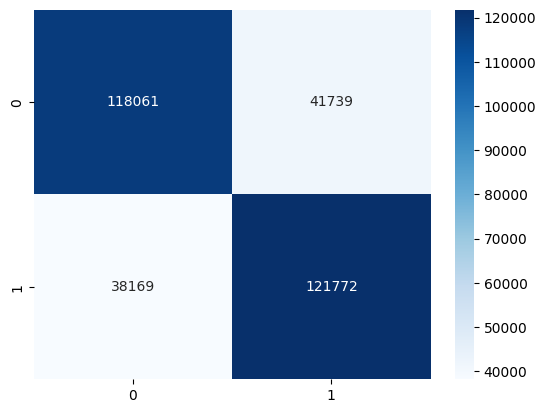

In [ ]:
print_heatmap(y_true, y_pred)

### 4.2 CountVectorizer

In [ ]:
y_true, y_pred, best_params = grid_search_hyperparameter_tuning(twitter_cv_df, regParams=[0.01, 0.05, 0.1], elasticNetParams=[0.2,0.6,0.8], tolParams=[1e-06, 1e-03],maxIter=20)

/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


F1 Score: 0.7464436625697647 found with parameters regParam:0.01 and elasticNetParam:0.2


/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


F1 Score: 0.7464760005113545 found with parameters regParam:0.01 and elasticNetParam:0.2


/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; h

In [ ]:
best_params

{'regParam': 0.01,
 'elasticNetParam': 0.2,
 'lrModel': LogisticRegressionModel: uid=LogisticRegression_da0d387ec9c5, numClasses=5, numFeatures=1000,
 'tolParam': 0.001}

In [ ]:
best_params['lrModel'].save('./cv_best')

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.69      0.73    159800
         4.0       0.72      0.81      0.76    159941

    accuracy                           0.75    319741
   macro avg       0.75      0.75      0.75    319741
weighted avg       0.75      0.75      0.75    319741



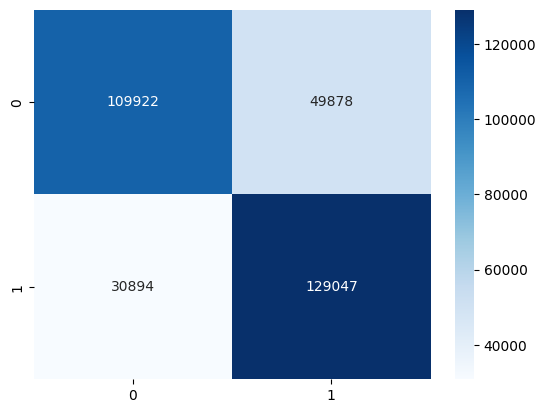

In [ ]:
print_heatmap(y_true, y_pred)

### 4.3 HashingTF

In [ ]:
y_true, y_pred, best_params = grid_search_hyperparameter_tuning(twitter_hash_df, regParams=[0.01, 0.05, 0.1], elasticNetParams=[0.2,0.6,0.8], tolParams=[1e-06, 1e-03],maxIter=20)

/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


F1 Score: 0.6468456921392969 found with parameters regParam:0.01 and elasticNetParam:0.2


/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; h

In [ ]:
best_params

{'regParam': 0.01,
 'elasticNetParam': 0.2,
 'lrModel': LogisticRegressionModel: uid=LogisticRegression_b327d3ba8e47, numClasses=5, numFeatures=200,
 'tolParam': 1e-06}

In [ ]:
best_params['lrModel'].save('./hashtf_best')

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.65      0.63      0.64    159800
         4.0       0.64      0.66      0.65    159941

    accuracy                           0.65    319741
   macro avg       0.65      0.65      0.65    319741
weighted avg       0.65      0.65      0.65    319741



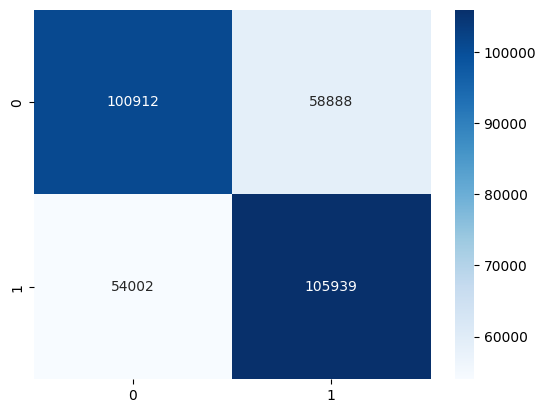

In [ ]:
print_heatmap(y_true, y_pred)

#